In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
from scipy.optimize import linear_sum_assignment

import torch
import torch.nn as nn
from torchvision import transforms as pth_transforms
from torch.distributions import Categorical

# import torch.nn.functional as F

%config Completer.use_jedi = False

device = torch.device("cuda:3")

import warnings
warnings.filterwarnings('ignore')

# notebook settings
np.set_printoptions(edgeitems=11,infstr='inf', linewidth=150, nanstr='nan', precision=3, suppress=True, threshold=20, formatter=None)
torch.set_printoptions(precision=2, threshold=None, edgeitems=10, linewidth=150, profile=None, sci_mode=None)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def set_global_seed(seed: int) -> None:
    """
    Sets random seed into PyTorch, TensorFlow, Numpy and Random.
    Args:
        seed: random seed
    """
    try:
        import torch
    except ImportError:
        pass
    else:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    try:
        import tensorflow as tf
    except ImportError:
        pass
    else:
        if parse(tf.__version__) >= Version("2.0.0"):
            tf.random.set_seed(seed)
        elif parse(tf.__version__) <= Version("1.13.2"):
            tf.set_random_seed(seed)
        else:
            tf.compat.v1.set_random_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

### Utility for plotting and image generation

In [3]:
''' Plots any given number of images'''
def plot_grid(*images, figsize=10, fignumber="Filter", titles=None, occurences=False):
    num_plots = len(images)
    
    plt.close(fignumber)
    fig = plt.figure(figsize=(figsize*int(min(num_plots, 5)), figsize*int(max(num_plots//5, 1))), num=fignumber)

    for i, grid in enumerate(images):
        
        size = grid.shape
        
        if size[-1] == 1:
            if occurences:
                cmap=None
            else:
                cmap="gray"
        else:
            cmap=None
        
        if len(size) == 3:
            ax = fig.add_subplot(((num_plots - 1) // 5) + 1, min(int(num_plots % 5) + (int(num_plots // 5) * 5), 5), i+1)
            img = grid.reshape(*size)
            ax.imshow(np.squeeze(img), cmap=cmap, vmin=0)
            ax.set_xticks([])
            ax.set_yticks([])
             
        if titles is not None:
            ax.set_title(titles[i], fontsize=figsize*3)
    
    plt.show()

In [4]:
''' Generates a random uniform RGB Image'''
#def generate_random_colors(nx=32, ny=32, reproduce_paper=True):
#    np.random.seed(3)
#    return np.random.uniform(0, 255, size=(nx, ny, 3)).astype(int)

def generate_random_colors(nx=32, ny=32, reproduce_paper=True):
    np.random.seed(3)
    X = np.random.uniform(0, 255, size=(nx, ny, 3)).astype(int)
    
    X = torch.from_numpy(X)
    return X

In [5]:
def load_paper_colors(path='data/colors_1024_random.png'):
    im = Image.open(path)
    data = torch.from_numpy(np.array(im)).float()
    data = data[:, :, 0:3]/255
    return data

In [6]:
def pretty_print(**args):
    for key in args.keys():
        print(key, end=': ')
        if isinstance(args[key], int):
            print('%4d' % args[key], end=' ')
        elif isinstance(args[key], torch.Tensor):
            args[key] = np.round(args[key].detach().cpu().numpy(), 3)
            print('%5.3f' % args[key], end=' ')
        elif isinstance(args[key], str):
            print('%s' % args[key], end=' ')
        elif isinstance(args[key], float):
            print('%5.3f' % args[key], end=' ')
    print()

In [7]:
def convert_images(*imgs, vmin=0, vmax=255):
    fig = plt.figure(figsize=(6, 2));
   
    for i, img in enumerate(imgs):
        fig.add_subplot(1, 3, i + 1)
        if isinstance(img, torch.Tensor):
            img = (img.detach().cpu().numpy()*255).astype(int)
        plt.imshow(img, vmin=vmin, vmax=vmax);
        plt.axis('off');
    return plt

## Distance Preservation Quality (DPQ)

In [8]:
def squared_l2_distance(q, p):
    
    ps = torch.sum(p * p, axis = 1, keepdim=True)
    qs = torch.sum(q * q, axis = 1, keepdim=True)
    p_q_transpose = torch.matmul(p, q.transpose(0, 1))

    squared_dists = ps - 2 * p_q_transpose + qs.transpose(0,1)
    return squared_dists 

In [9]:
''' Converts a given gridshape to a grid index matrix
    and calculates the squared spatial distances '''

def compute_spatial_distances_for_grid(grid_shape, wrap):
    if wrap:
        return compute_spatial_distances_for_grid_wrapped(grid_shape)
    else:
        return compute_spatial_distances_for_grid_non_wrapped(grid_shape)


def compute_spatial_distances_for_grid_wrapped(grid_shape):
    n_x = grid_shape[0]
    n_y = grid_shape[1]

    wrap1 = [[0, 0], [0, 0], [0, 0], [0, n_y], [0, n_y], [n_x, 0], [n_x, 0], [n_x, n_y]]
    wrap2 = [[0, n_y], [n_x, 0], [n_x, n_y], [0, 0], [n_x, 0], [0, 0], [0, n_y], [0, 0]]

    # create 2D position matrix with tuples, i.e. [(0,0), (0,1)...(H-1, W-1)]
    a, b = np.indices(grid_shape)
    mat = np.concatenate([np.expand_dims(a, -1), np.expand_dims(b, -1)], axis=-1)
    mat_flat = mat.reshape((-1, 2))

    # use this 2D matrix to calculate spatial distances between on positions on the grid
    d = squared_l2_distance(mat_flat, mat_flat)
    for i in range(8):
        # look for smaller distances with wrapped coordinates
        d_i = squared_l2_distance(mat_flat + wrap1[i], mat_flat + wrap2[i])
        d = np.minimum(d, d_i)

    return d


def compute_spatial_distances_for_grid_non_wrapped(grid_shape):
    # create 2D position matrix with tuples, i.e. [(0,0), (0,1)...(H-1, W-1)]
    a, b = torch.tensor(np.indices(grid_shape))
    a, b = a.type(torch.FloatTensor), b.type(torch.FloatTensor)
    mat = torch.cat([a[:, :, None], b[:, :, None]], axis=-1)
    mat_flat = mat.view((-1, 2))

    # use this 2D matrix to calculate spatial distances between on positions on the grid
    d = squared_l2_distance(mat_flat, mat_flat)
    return d

In [10]:
def sort_hddists_by_2d_dists_fast(hd_dists, ld_dists, device):
    hd_dists = hd_dists.type(torch.FloatTensor).to(device)
    max_hd_dist = torch.max(hd_dists) * 1.0001

    ld_hd_dists = (hd_dists/max_hd_dist + ld_dists).to(device)   # add the normed HD distances (0 .. 0.999) to the 2D integer distances
    ld_hd_dists = torch.sort(ld_hd_dists)[0]    # then a normal sorting of the rows can be used

    sorted_HD_D = torch.fmod(ld_hd_dists, 1) * max_hd_dist

    return sorted_HD_D

In [11]:
''' computes the Distance Preservation Gain delta DP_k(S) '''
def get_distance_preservation_gain(sorted_d_mat, d_mean, device):
    # range of numbers [1, K], with K = N-1
    nums = torch.arange(1, len(sorted_d_mat)).to(device)

    # compute cumulative sum of neighbor distance values for all rows, shape = (N, K)
    cumsum = torch.cumsum(sorted_d_mat[:, 1:], axis=1)

    # compute average of neighbor distance values for all rows, shape = (N, K)
    d_k = cumsum / nums

    # compute average of all rows for each k, shape = (K, )
    d_k = d_k.mean(axis=0)

    # compute Distance Preservation Gain and set negative values to 0, shape = (K, )
    # d_k = torch.maximum((d_mean - d_k) / d_mean, torch.tensor0)
    d_k = torch.clip((d_mean - d_k) / d_mean, 0, 1)
    return d_k

In [12]:
''' computes the Distance Preservation Quality DPQ_p(S) '''
def dpq(sorted_X, device, p=2, wrap=False):
    sorted_X.to(device)

    # setup of required variables
    grid_shape = sorted_X.shape[:-1]
    dim = sorted_X.shape[-1]
    N = np.prod(grid_shape)

    # compute matrix of euclidean distances in the high dimensional space
    dists_HD = torch.cdist(sorted_X.reshape(-1, dim), sorted_X.reshape(-1, dim), p=2).to(device)

    # sort HD distance matrix rows in acsending order (first value is always 0 zero now)
    sorted_D = torch.sort(dists_HD, -1)[0]

    # compute the expected value of the HD distance matrix
    mean_D = torch.mean(sorted_D[:, 1:])

    # compute spatial distance matrix for each position on the 2D grid (squared for integer dists)
    dists_spatial = compute_spatial_distances_for_grid(grid_shape, wrap).to(device)

    # sort rows of HD distances by the values of spatial distances
    sorted_HD_by_2D = sort_hddists_by_2d_dists_fast(dists_HD, dists_spatial, device)
    
    # get delta DP_k values
    delta_DP_k_2D = get_distance_preservation_gain(sorted_HD_by_2D, mean_D, device)
    delta_DP_k_HD = get_distance_preservation_gain(sorted_D, mean_D, device)

    # compute p norm of DP_k values
    normed_delta_D_2D_k = torch.linalg.norm(delta_DP_k_2D, ord=p)
    normed_delta_D_HD_k = torch.linalg.norm(delta_DP_k_HD, ord=p)

    # DPQ(s) is the ratio between the two normed DP_k values
    DPQ = normed_delta_D_2D_k / normed_delta_D_HD_k

    return DPQ

##  Loss Functions

In [13]:
def dist_matrix_loss_func(x_shuffled, x_sorted, p_dist):
    # distance matrix of the original (shuffled) data and of the shuffled (permuted) matrix
    dist_x_sorted = torch.cdist(x_sorted, x_sorted) ** p_dist
    dist_x_shuffled = torch.cdist(x_shuffled, x_shuffled) ** p_dist

    # doubly sorted distance matrices
    dist_x_shuffled_sort = torch.sort(torch.sort(dist_x_shuffled, 0)[0], 1)[0]
    dist_x_sorted_sort = torch.sort(torch.sort(dist_x_sorted, 0)[0], 1)[0]

    mean_dist_x_shuffled = torch.mean(dist_x_shuffled_sort)
    
    loss_distmatrix = (torch.mean(torch.abs(dist_x_shuffled_sort - dist_x_sorted_sort)) / mean_dist_x_shuffled) 

    return loss_distmatrix

In [14]:
def neighbor_loss_func(x_shuffled, x_sorted, k, p_dist):
    
    n = k * k

    dist_x_shuffled = torch.cdist(x_shuffled, x_shuffled, p=2) ** p_dist
    dist_x_sorted = torch.cdist(x_sorted, x_sorted, p=2) ** p_dist
    
    mean_dist_x_shuffled = dist_x_shuffled.mean()
    
    dist_hor = torch.diag(dist_x_sorted, diagonal=1)
    ind = torch.arange(n - 1)
    bool_index = (ind + 1) % k != 0
    dist_hor = dist_hor[bool_index]
    dist_hor_mean = torch.mean(dist_hor)

    dist_ver = torch.diag(dist_x_sorted, diagonal=k)
    dist_ver_mean = torch.mean(dist_ver)

    dist_neighbors = (0.5 * dist_hor_mean + 0.5 * dist_ver_mean) / mean_dist_x_shuffled  # mean distance horizontal and vertical

    return dist_neighbors

In [15]:
def constraint_loss(perm):
    constraintPenalty = torch.mean((torch.sum(perm, dim=0) - 1) ** 2) \
                      + torch.mean((torch.sum(perm, dim=1) - 1) ** 2)
    return constraintPenalty

## Sorting Networks

In [16]:
import torch
import torch.nn as nn

class MultiheadAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(MultiheadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(d_model, nhead)

    def forward(self, x, mask=None):
        return self.attention(x, x, x, attn_mask=mask)[0]



class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.0):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = x + self.dropout(self.self_attn(x, mask))
        x = self.norm1(x)
        x = x + self.dropout(self.feedforward(x))
        x = self.norm2(x)
        return x

class Transformer(nn.Module):
    def __init__(self, input_size, n, d_model=512, n_heads=1, num_layers=4):
        super(Transformer, self).__init__()
        
        scale = d_model ** -0.5

        self.embedding = nn.Linear(input_size, d_model)
        self.positional_embedding = nn.Parameter(scale * torch.randn(n + 1, d_model))

        scale = d_model ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(d_model))

        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(d_model, n_heads) for _ in range(num_layers)])
        
        self.out_Layer = nn.Linear(d_model, n**2, )

    def forward(self, src):
        #print("in", src.shape)
        src = self.embedding(src)
        #print("emb", src.shape)
        src = torch.cat([self.class_embedding.unsqueeze(0).to(src.dtype), src], dim=0)
        #print("c added", src.shape)
        src = src + self.positional_embedding.to(src.dtype)
        #print("pos added", src.shape)
        
        for layer in self.encoder_layers:
            src = layer(src)

        # Return the class token only
        transformer_output = src[0, :]
        out = self.out_Layer(transformer_output)
        return out

In [17]:
class Gumbel_Sinkhorn_Transformer_Network(torch.nn.Module):
    def __init__(self, input_dim, n, d_model, n_iter, num_layers, n_heads):
        super(Gumbel_Sinkhorn_Transformer_Network, self).__init__()
        self.n = n
        self.n_iter = n_iter
        
        self.transformer = Transformer(input_dim, n, d_model, num_layers=num_layers, n_heads=n_heads)

    def forward(self, in_x, tau=1, noise_factor=0):
        
        x = self.transformer(in_x)
        x = x.reshape(self.n, self.n)  # reshape for sinkhorn operation

        P_hat = gumbel_sinkhorn(x, tau, self.n_iter, noise_factor)

        P = torch.zeros_like(P_hat, device=P_hat.device)
        P.scatter_(-1, P_hat.topk(1, -1)[1], value=1)
        P_hat_hard = (P - P_hat).detach() + P_hat

        return P_hat, P_hat_hard
    
def gumbel_sinkhorn(log_alpha: torch.Tensor, tau: float = 1.0, n_iter: int = 20, noise_factor: float = 0) -> (torch.Tensor,):
    uniform_noise = torch.rand_like(log_alpha)
    gumbel_noise = -torch.log(-torch.log(uniform_noise + 1e-20) + 1e-20)
    log_alpha = log_alpha + noise_factor * gumbel_noise

    sampled_perm_mat = log_sinkhorn_norm(log_alpha / tau, n_iter)
    return sampled_perm_mat

def log_sinkhorn_norm(log_alpha: torch.Tensor, n_iter: int = 20) -> (torch.Tensor,):
    for _ in range(n_iter):
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -2, keepdim=True)
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -1, keepdim=True)

    return log_alpha.exp()

In [18]:
class Gumbel_Sinkhorn_Network(torch.nn.Module):
    def __init__(self, n, n_iter, device):
        super(Gumbel_Sinkhorn_Network, self).__init__()
        self.n = n
        self.n_iter = n_iter
        self.W = torch.nn.Parameter(torch.rand((n*n)), requires_grad=True)

    def forward(self, tau=1, noise_factor=0):
        x = self.W.reshape(self.n, self.n)  # reshape for sinkhorn operation

        P_hat = gumbel_sinkhorn(x, tau, self.n_iter, noise_factor)

        P = torch.zeros_like(P_hat, device=P_hat.device)
        P.scatter_(-1, P_hat.topk(1, -1)[1], value=1)
        P_hat_hard = (P - P_hat).detach() + P_hat

        return P_hat, P_hat_hard
    
def gumbel_sinkhorn(log_alpha: torch.Tensor, tau: float = 1.0, n_iter: int = 20, noise_factor: float = 0) -> (torch.Tensor,):
    uniform_noise = torch.rand_like(log_alpha)
    gumbel_noise = -torch.log(-torch.log(uniform_noise + 1e-20) + 1e-20)
    log_alpha = log_alpha + noise_factor * gumbel_noise

    sampled_perm_mat = log_sinkhorn_norm(log_alpha / tau, n_iter)
    return sampled_perm_mat

def log_sinkhorn_norm(log_alpha: torch.Tensor, n_iter: int = 20) -> (torch.Tensor,):
    for _ in range(n_iter):
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -2, keepdim=True)
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -1, keepdim=True)

    return log_alpha.exp()

In [19]:
class Neural_Sort_Network (torch.nn.Module):
    def __init__(self, n, device):
        super(Neural_Sort_Network, self).__init__()
        self.W = torch.nn.Parameter(0.1*torch.rand((n)), requires_grad=True)
        

    def forward(self, tau=1, noise_factor=0):
        dyn_range = self.W.max() - self.W.min()
        x = self.W.view(1, -1, 1)

        x = x + noise_factor * dyn_range * torch.randn_like(x)
        x_sorted = x.sort(descending=False, dim=1)[0]
        pairwise_diff = (x.transpose(1, 2) - x_sorted).abs().neg() / tau
        P_hat = pairwise_diff.softmax(-1)

        P = torch.zeros_like(P_hat, device=P_hat.device)
        P.scatter_(-1, P_hat.topk(1, -1)[1], value=1)
        P_hat_hard = (P - P_hat).detach() + P_hat

        P_hat = P_hat.squeeze()
        P_hat_hard = P_hat_hard.squeeze()

        return P_hat, P_hat_hard

In [20]:
class Kissing_Network (torch.nn.Module):
    def __init__(self, n, device):
        super(Kissing_Network, self).__init__()     
        m = 15 # TODO: richtige Zahl jeweils für n ausrechnen
        
        self.V = torch.nn.Parameter(torch.rand((n,m)),requires_grad=True)
        self.W = torch.nn.Parameter(torch.rand((n,m)),requires_grad=True)      

    def forward(self, tau=1, noise_factor=0):
        beta=20

        norm = lambda x:  x/torch.sqrt(torch.sum(x**2,1))[:,None]
        ATB = lambda A,B: norm(A) @ norm(B).T
        x = lambda A,B: torch.nn.functional.softmax(beta * 2 * (ATB(A,B) / tau), dim=0)
   
        P_hat = x(self.V,self.W)

        P = torch.zeros_like(P_hat, device=P_hat.device)
        P.scatter_(-1, P_hat.topk(1, -1)[1], value=1)
        P_hat_hard = (P - P_hat).detach() + P_hat

        P_hat = P_hat.squeeze()
        P_hat_hard = P_hat_hard.squeeze()

        return P_hat, P_hat_hard

# Learning sorted arrangements

## Gumbel Sinkhorn

In [21]:
# Parameters
dpq_p = 16           # power of the DPQ calculation

seed = 0  # 0
iterations = 5000
learning_rate = 0.05 #03 # 0.11
n_iter = 15 # 40      # sinkhorn iterations
tau = 1              # sinkhorn (1)
noise_factor = 0.1   # factor for the gumbel noise 0 .. 1 (0.1)
p_dist = 2           # power of the distances for the loss functions 

x_orig = load_paper_colors()
ny, nx = x_orig.shape[0:2]
n = nx * ny

it:    0 L: 0.000 dist_nb: 0.000 L_dm: 1.000 L_c: 0.000 D:  370 DPQ_S: 0.344 DPQ_H: 0.351 DPQ_L: 0.330 
it:  200 L: 0.023 dist_nb: 0.012 L_dm: 0.052 L_c: 0.000 D:  186 DPQ_S: 0.978 DPQ_H: 0.927 DPQ_L: 0.937 
it:  400 L: 0.028 dist_nb: 0.015 L_dm: 0.031 L_c: 0.000 D:  145 DPQ_S: 0.977 DPQ_H: 0.943 DPQ_L: 0.943 
it:  600 L: 0.031 dist_nb: 0.018 L_dm: 0.021 L_c: 0.000 D:  118 DPQ_S: 0.972 DPQ_H: 0.947 DPQ_L: 0.944 
it:  800 L: 0.033 dist_nb: 0.022 L_dm: 0.013 L_c: 0.000 D:   50 DPQ_S: 0.965 DPQ_H: 0.945 DPQ_L: 0.944 
it: 1000 L: 0.034 dist_nb: 0.025 L_dm: 0.007 L_c: 0.000 D:   29 DPQ_S: 0.958 DPQ_H: 0.944 DPQ_L: 0.944 
it: 1200 L: 0.034 dist_nb: 0.028 L_dm: 0.004 L_c: 0.000 D:   11 DPQ_S: 0.954 DPQ_H: 0.944 DPQ_L: 0.943 
it: 1400 L: 0.034 dist_nb: 0.029 L_dm: 0.003 L_c: 0.000 D:    6 DPQ_S: 0.951 DPQ_H: 0.943 DPQ_L: 0.943 
it: 1600 L: 0.034 dist_nb: 0.030 L_dm: 0.002 L_c: 0.000 D:    4 DPQ_S: 0.949 DPQ_H: 0.944 DPQ_L: 0.944 
it: 1800 L: 0.034 dist_nb: 0.031 L_dm: 0.002 L_c: 0.000 D:    4 

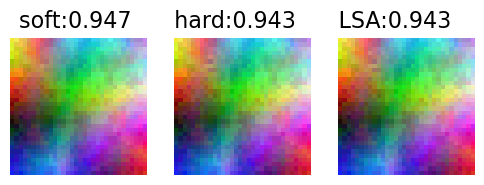

In [22]:
USE_TRANFORMER = True

set_global_seed(seed)

x_shuffled = x_orig.reshape(-1,3)[torch.randperm(n)].to(device)

# select one of the networks
# net = Neural_Sort_Network(n, device=device).to(device)  # n parameters
# net = Kissing_Network(n, device=device).to(device)  # 2*n*m parameters
if USE_TRANFORMER:
    net = Gumbel_Sinkhorn_Transformer_Network(input_dim=x_shuffled.shape[-1], n=n, d_model=16, num_layers=3, n_iter=n_iter, n_heads=4).to(device)
else:
    net = Gumbel_Sinkhorn_Network(n, n_iter=n_iter, device=device).to(device) # n*n parameters

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for iteration in range(iterations+1):
    optimizer.zero_grad()

    alpha = np.maximum(np.minimum(1, iteration / (iterations + 1)), 0)
    
    if USE_TRANFORMER:
        perm_soft, perm_hard = net(x_shuffled, tau, noise_factor)
    else:
        perm_soft, perm_hard = net(tau, noise_factor)
    # perm_soft, perm_hard = net(tau, (1-alpha)*noise_factor)
    
    x_sorted_soft = torch.matmul(perm_soft, x_shuffled)
    x_sorted_hard = torch.matmul(perm_hard, x_shuffled)
    
    loss_dist_neighbors = neighbor_loss_func(x_shuffled, x_sorted_soft, nx, p_dist)  
    loss_dist_matrix = dist_matrix_loss_func(x_shuffled, x_sorted_soft, p_dist)    
    loss_constrain = constraint_loss(perm_soft)
    
    loss = 0
    loss += loss_dist_neighbors
    loss += 5*alpha * loss_dist_matrix
    loss += 100*loss_constrain
    
    ind = torch.argmax(perm_hard, -1)
    num_duplicates = int(n - torch.unique(ind).shape[0])
    
    end = iteration == iterations or num_duplicates == 0

    if iteration % 200 == 0 or end:
        dist = torch.cdist(x_sorted_soft, x_shuffled, p=p_dist)
        _, ind = linear_sum_assignment(dist.detach().cpu().numpy())
        x_sorted_soft = x_sorted_soft.view(ny, nx, -1)
        x_sorted_hard = x_sorted_hard.view(ny, nx, -1)
        x_sorted_las = x_shuffled[ind].view(ny, nx, -1)
        
        dpq_S = dpq(x_sorted_soft, p=dpq_p, device=device)
        dpq_H = dpq(x_sorted_hard, p=dpq_p, device=device)
        dpq_L = dpq(x_sorted_las,  p=dpq_p, device=device)
        dpq_str = f"soft:{dpq_S:.3f}      hard:{dpq_H:.3f}      LSA:{dpq_L:.3f}"

        pretty_print(
            it=iteration,
            L=loss,
            dist_nb=loss_dist_neighbors,
            L_dm=loss_dist_matrix,
            L_c=loss_constrain,
            D=num_duplicates,
            DPQ_S=dpq_S, DPQ_H=dpq_H, DPQ_L=dpq_L)

    if end:
        break
        
    loss.backward()
    optimizer.step()

p = convert_images(x_sorted_soft, x_sorted_hard, x_sorted_las)
p.suptitle(dpq_str, fontsize=16);

it:    0 L: 0.000 dist_nb: 0.000 L_dm: 1.000 L_c: 0.000 D:  380 DPQ_S: 0.361 DPQ_H: 0.335 DPQ_L: 0.348 
it:  200 L: 0.197 dist_nb: 0.000 L_dm: 0.985 L_c: 0.000 D:  411 DPQ_S: 0.948 DPQ_H: 0.566 DPQ_L: 0.837 
it:  400 L: 0.097 dist_nb: 0.011 L_dm: 0.216 L_c: 0.000 D:  374 DPQ_S: 0.949 DPQ_H: 0.855 DPQ_L: 0.910 
it:  600 L: 0.047 dist_nb: 0.017 L_dm: 0.051 L_c: 0.000 D:  211 DPQ_S: 0.962 DPQ_H: 0.929 DPQ_L: 0.932 
it:  800 L: 0.037 dist_nb: 0.022 L_dm: 0.019 L_c: 0.000 D:  122 DPQ_S: 0.959 DPQ_H: 0.941 DPQ_L: 0.937 
it: 1000 L: 0.037 dist_nb: 0.025 L_dm: 0.012 L_c: 0.000 D:   69 DPQ_S: 0.955 DPQ_H: 0.940 DPQ_L: 0.937 
it: 1200 L: 0.037 dist_nb: 0.027 L_dm: 0.008 L_c: 0.000 D:   34 DPQ_S: 0.952 DPQ_H: 0.939 DPQ_L: 0.937 
it: 1400 L: 0.037 dist_nb: 0.029 L_dm: 0.005 L_c: 0.000 D:   20 DPQ_S: 0.949 DPQ_H: 0.939 DPQ_L: 0.938 
it: 1600 L: 0.037 dist_nb: 0.030 L_dm: 0.004 L_c: 0.000 D:   16 DPQ_S: 0.946 DPQ_H: 0.938 DPQ_L: 0.938 
it: 1800 L: 0.037 dist_nb: 0.031 L_dm: 0.003 L_c: 0.000 D:   10 

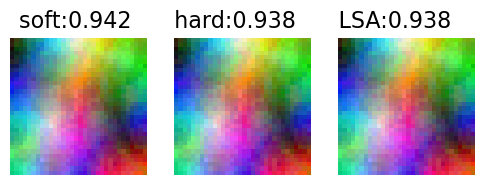

In [27]:
USE_TRANFORMER = False

set_global_seed(seed)

x_shuffled = x_orig.reshape(-1,3)[torch.randperm(n)].to(device)

# select one of the networks
# net = Neural_Sort_Network(n, device=device).to(device)  # n parameters
# net = Kissing_Network(n, device=device).to(device)  # 2*n*m parameters
if USE_TRANFORMER:
    net = Gumbel_Sinkhorn_Transformer_Network(input_dim=x_shuffled.shape[-1], n=n, d_model=16, num_layers=3, n_iter=n_iter, n_heads=4).to(device)
else:
    net = Gumbel_Sinkhorn_Network(n, n_iter=n_iter, device=device).to(device) # n*n parameters

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for iteration in range(iterations+1):
    optimizer.zero_grad()

    alpha = np.maximum(np.minimum(1, iteration / (iterations + 1)), 0)
    
    if USE_TRANFORMER:
        perm_soft, perm_hard = net(x_shuffled, tau, noise_factor)
    else:
        perm_soft, perm_hard = net(tau, noise_factor)
    # perm_soft, perm_hard = net(tau, (1-alpha)*noise_factor)
    
    x_sorted_soft = torch.matmul(perm_soft, x_shuffled)
    x_sorted_hard = torch.matmul(perm_hard, x_shuffled)
    
    loss_dist_neighbors = neighbor_loss_func(x_shuffled, x_sorted_soft, nx, p_dist)  
    loss_dist_matrix = dist_matrix_loss_func(x_shuffled, x_sorted_soft, p_dist)    
    loss_constrain = constraint_loss(perm_soft)
    
    loss = 0
    loss += loss_dist_neighbors
    loss += 5*alpha * loss_dist_matrix
    loss += 100*loss_constrain
    
    ind = torch.argmax(perm_hard, -1)
    num_duplicates = int(n - torch.unique(ind).shape[0])
    
    end = iteration == iterations or num_duplicates == 0

    if iteration % 200 == 0 or end:
        dist = torch.cdist(x_sorted_soft, x_shuffled, p=p_dist)
        _, ind = linear_sum_assignment(dist.detach().cpu().numpy())
        x_sorted_soft = x_sorted_soft.view(ny, nx, -1)
        x_sorted_hard = x_sorted_hard.view(ny, nx, -1)
        x_sorted_las = x_shuffled[ind].view(ny, nx, -1)
        
        dpq_S = dpq(x_sorted_soft, p=dpq_p, device=device)
        dpq_H = dpq(x_sorted_hard, p=dpq_p, device=device)
        dpq_L = dpq(x_sorted_las,  p=dpq_p, device=device)
        dpq_str = f"soft:{dpq_S:.3f}      hard:{dpq_H:.3f}      LSA:{dpq_L:.3f}"

        pretty_print(
            it=iteration,
            L=loss,
            dist_nb=loss_dist_neighbors,
            L_dm=loss_dist_matrix,
            L_c=loss_constrain,
            D=num_duplicates,
            DPQ_S=dpq_S, DPQ_H=dpq_H, DPQ_L=dpq_L)

    if end:
        break
        
    loss.backward()
    optimizer.step()

p = convert_images(x_sorted_soft, x_sorted_hard, x_sorted_las)
p.suptitle(dpq_str, fontsize=16);

## Kissing

In [23]:
# Parameters
dpq_p = 16           # power of the DPQ calculation

seed = 0  # 0
iterations = 5000
learning_rate = 0.01 #03 # 0.11
n_iter = 15 # 40      # sinkhorn iterations
tau = 1              # sinkhorn (1)
noise_factor = 0.1   # factor for the gumbel noise 0 .. 1 (0.1)
p_dist = 2           # power of the distances for the loss functions 

x_orig = load_paper_colors()
ny, nx = x_orig.shape[0:2]
n = nx * ny

it:    0 L: 19.885 dist_nb: 1.378 L_dm: 0.778 L_c: 0.389 D:  405 DPQ_S: 0.487 DPQ_H: 0.355 DPQ_L: 0.349 
it:  200 L: 1.648 dist_nb: 0.114 L_dm: 0.692 L_c: 0.001 D:  262 DPQ_S: 0.637 DPQ_H: 0.514 DPQ_L: 0.601 
it:  400 L: 0.718 dist_nb: 0.272 L_dm: 0.052 L_c: 0.002 D:   53 DPQ_S: 0.671 DPQ_H: 0.628 DPQ_L: 0.653 
it:  600 L: 0.581 dist_nb: 0.254 L_dm: 0.009 L_c: 0.001 D:   28 DPQ_S: 0.688 DPQ_H: 0.658 DPQ_L: 0.673 
it:  800 L: 0.529 dist_nb: 0.231 L_dm: 0.007 L_c: 0.001 D:   31 DPQ_S: 0.705 DPQ_H: 0.669 DPQ_L: 0.687 
it: 1000 L: 0.495 dist_nb: 0.218 L_dm: 0.007 L_c: 0.001 D:   38 DPQ_S: 0.714 DPQ_H: 0.679 DPQ_L: 0.696 
it: 1200 L: 0.469 dist_nb: 0.206 L_dm: 0.007 L_c: 0.001 D:   32 DPQ_S: 0.721 DPQ_H: 0.685 DPQ_L: 0.705 
it: 1400 L: 0.451 dist_nb: 0.197 L_dm: 0.006 L_c: 0.001 D:   30 DPQ_S: 0.724 DPQ_H: 0.689 DPQ_L: 0.709 
it: 1600 L: 0.435 dist_nb: 0.189 L_dm: 0.006 L_c: 0.001 D:   34 DPQ_S: 0.734 DPQ_H: 0.695 DPQ_L: 0.723 
it: 1800 L: 0.426 dist_nb: 0.184 L_dm: 0.006 L_c: 0.001 D:   33

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


it: 5000 L: 0.344 dist_nb: 0.146 L_dm: 0.006 L_c: 0.001 D:   40 DPQ_S: 0.769 DPQ_H: 0.728 DPQ_L: 0.749 


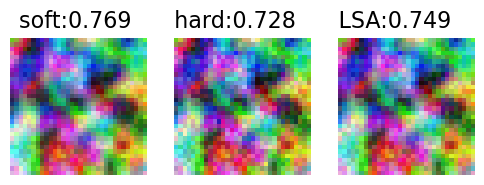

In [24]:
set_global_seed(seed)

x_shuffled = x_orig.reshape(-1,3)[torch.randperm(n)].to(device)

# select one of the networks
# net = Neural_Sort_Network(n, device=device).to(device)  # n parameters
net = Kissing_Network(n, device=device).to(device)  # 2*n*m parameters
# net = Gumbel_Sinkhorn_Network(n, n_iter=n_iter, device=device).to(device) # n*n parameters

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for iteration in range(iterations+1):
    optimizer.zero_grad()

    alpha = np.maximum(np.minimum(1, iteration / (iterations + 1)), 0)

    perm_soft, perm_hard = net(tau, noise_factor)
    # perm_soft, perm_hard = net(tau, (1-alpha)*noise_factor)
    
    x_sorted_soft = torch.matmul(perm_soft, x_shuffled)
    x_sorted_hard = torch.matmul(perm_hard, x_shuffled)
    
    loss_dist_neighbors = neighbor_loss_func(x_shuffled, x_sorted_soft, nx, p_dist)  
    loss_dist_matrix = dist_matrix_loss_func(x_shuffled, x_sorted_soft, p_dist)    
    loss_constrain = constraint_loss(perm_soft)
    
    loss = 0
    loss += 2*loss_dist_neighbors
    loss += 2* loss_dist_matrix
    loss += 40*loss_constrain
    
    ind = torch.argmax(perm_hard, -1)
    num_duplicates = int(n - torch.unique(ind).shape[0])
    
    end = iteration == iterations or num_duplicates == 0

    if iteration % 200 == 0 or end:
        dist = torch.cdist(x_sorted_soft, x_shuffled, p=p_dist)
        _, ind = linear_sum_assignment(dist.detach().cpu().numpy())
        x_sorted_soft = x_sorted_soft.view(ny, nx, -1)
        x_sorted_hard = x_sorted_hard.view(ny, nx, -1)
        x_sorted_las = x_shuffled[ind].view(ny, nx, -1)
        
        dpq_S = dpq(x_sorted_soft, p=dpq_p, device=device)
        dpq_H = dpq(x_sorted_hard, p=dpq_p, device=device)
        dpq_L = dpq(x_sorted_las,  p=dpq_p, device=device)
        dpq_str = f"soft:{dpq_S:.3f}      hard:{dpq_H:.3f}      LSA:{dpq_L:.3f}"

        pretty_print(
            it=iteration,
            L=loss,
            dist_nb=loss_dist_neighbors,
            L_dm=loss_dist_matrix,
            L_c=loss_constrain,
            D=num_duplicates,
            DPQ_S=dpq_S, DPQ_H=dpq_H, DPQ_L=dpq_L)

    if end:
        break
        
    loss.backward()
    optimizer.step()

p = convert_images(x_sorted_soft, x_sorted_hard, x_sorted_las)
p.suptitle(dpq_str, fontsize=16);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


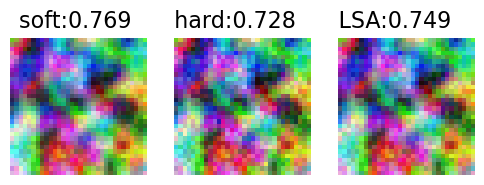

In [25]:
#    loss += 2*loss_dist_neighbors
#    loss += 2*alpha * loss_dist_matrix
#    loss += 100*loss_constrain
p = convert_images(x_sorted_soft, x_sorted_hard, x_sorted_las)
p.suptitle(dpq_str, fontsize=16);